In [1]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import osmnx as ox
import contextily as cx
import numpy as np
import joblib
import math
from pyrosm import OSM, get_data

from osmium.geom import haversine_distance
import osmium

In [2]:
osm_fp = "./openstreetmap data/porto.osm.pbf"
osm = OSM(osm_fp)

# Parse roads that can be driven by car
# roads = osm.get_network(network_type="driving")
# roads.plot(figsize=(10,10))

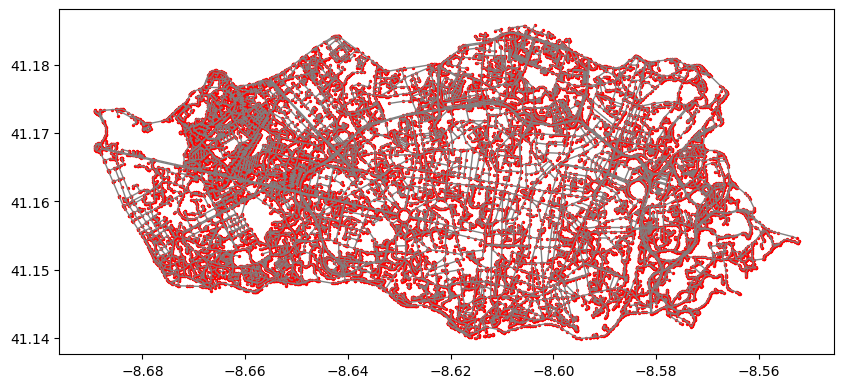

In [3]:
# Parse nodes and edges
road_nodes, road_edges = osm.get_network(network_type="driving", nodes=True)

# Plot the data
ax = road_edges.plot(figsize=(10,10), color="gray", lw=1.0)
ax = road_nodes.plot(ax=ax, color="red", markersize=2)

In [48]:
data_folder = "./openstreetmap data/"
stcp_nodes = gpd.read_file(data_folder + "stcp_nodes.gpkg")
stcp_edges = gpd.read_file(data_folder + "stcp_edges_time.gpkg")
metro_nodes = gpd.read_file(data_folder + "metro_nodes.gpkg")
metro_edges = gpd.read_file(data_folder + "metro_edges_time.gpkg")

In [49]:
stcp_nodes

id               timestamp tags  visible  version       lon  \
0     1ADA1 2024-11-16 14:31:45.227  bus     True        1 -8.613556   
1      1AL2 2024-11-16 14:31:45.227  bus     True        1 -8.610069   
2      1AL6 2024-11-16 14:31:45.227  bus     True        1 -8.610010   
3      1BS2 2024-11-16 14:31:45.227  bus     True        1 -8.627762   
4      1BS3 2024-11-16 14:31:45.227  bus     True        1 -8.628206   
..      ...                     ...  ...      ...      ...       ...   
979  1SBNT1 2024-11-16 14:31:45.227  bus     True        1 -8.610738   
980   1SJB1 2024-11-16 14:31:45.227  bus     True        1 -8.649633   
981   1SJB2 2024-11-16 14:31:45.227  bus     True        1 -8.649802   
982     AL2 2024-11-16 14:31:45.227  bus     True        1 -8.610846   
983    PRF4 2024-11-16 14:31:45.227  bus     True        1 -8.591952   

           lat  changeset                   geometry  
0    41.171644          1  POINT (-8.61356 41.17164)  
1    41.149515          1  POINT (-8.61007 41.14951)  
2    41.149118          1  POINT (-8.61001 41.14912)  
3    41.155925          1  POINT (-8.62776 41.15593)  
4    41.154471          1  POINT (-8.62821 41.15447)  
..         ...        ...                        ...  
979  41.144586          1  POINT (-8.61074 41.14459)  
980  41.166645          1  POINT (-8.64963 41.16665)  
981  41.166604          1  POINT (-8.64980 41.16660)  
982  41.147521          1  POINT (-8.61085 41.14752)  
983  41.156306          1  POINT (-8.59195 41.15631)  

[984 rows x 9 columns]

In [45]:
# remove stcp nodes with id 'BSEE1' and 'CTV1'

stcp_nodes.drop(stcp_nodes[stcp_nodes['id'].isin(['BSEE1', 'CTV1'])].index, inplace=True)



In [46]:
import datetime
import shapely 
# example 'COMB2': {'osmid': 'COMB2', 'timestamp': Timestamp('2024-11-16 14:31:45.227000'), 'tags': 'bus', 'visible': True, 'version': 1, 'x': -8.60070467772582, 'y': 41.1645989919441, 'changeset': 1, 'geometry': <POINT (-8.601 41.165)>}
# stop_id;stop_code;stop_name;stop_lat;stop_lon;zone_id;stop_url
# BSEE1;BSEE1;BR. STO.EUGÉNIO (ESCOLA);41.1791162981376;-8.63750113300492;PRT2;http://www.stcp.pt/pt/viajar/paragens/?t=detalhe&paragem=BSEE1
# stop_id;stop_code;stop_name;stop_lat;stop_lon;zone_id;stop_url
# CTV1;CTV1;COTOVIAS;41.1806389120409;-8.63663889115891;PRT2;http://www.stcp.pt/pt/viajar/paragens/?t=detalhe&paragem=CTV1
# add these nodes
new_stcp_nodes = pd.DataFrame({'id': ['BSEE1', 'CTV1'], 'timestamp': [datetime.datetime.now(), datetime.datetime.now()], 'tags': ['bus', 'bus'], 'visible': [True, True], 'version': [1, 1], 'x': [-8.63750113300492,  -8.63663889115891], 'y': [41.1791162981376, 41.1806389120409], 'changeset': [1, 1], 'geometry': [shapely.geometry.Point(-8.63750113300492, 41.1791162981376), shapely.geometry.Point(-8.63663889115891, 41.1806389120409)]})
# new_stcp_nodes
stcp_nodes = pd.concat([stcp_nodes, new_stcp_nodes])

In [50]:
stcp_nodes.crs = "EPSG:4326"
stcp_edges.crs = "EPSG:4326"
metro_edges.crs = "EPSG:4326"
metro_nodes.crs = "EPSG:4326"

G = osm.to_graph(stcp_nodes, stcp_edges, graph_type="networkx", retain_all=True)

In [ ]:
type(stcp_nodes)

In [ ]:
# metro_edges u and v as string
# metro_edges['u'] = metro_edges['u'].astype(str)
# metro_edges['v'] = metro_edges['v'].astype(str)

In [ ]:
# metro_nodes
# metro_nodes['id'] = metro_nodes['id'].astype(str)

Add metro nodes and edges to the bus graph

In [51]:
for metro_node in metro_nodes.to_dict(orient='records'):
    G.add_node(metro_node['id'], timestamp=metro_node['timestamp'], tags=metro_node['tags'], visible=metro_node['visible'], version=metro_node['version'], x=metro_node['lon'], y=metro_node['lat'], changeset=metro_node['changeset'], geometry=metro_node['geometry'])

In [52]:
# check for edges that use u and v that do not exist in metro_nodes
metro_nodes_ids = metro_nodes['id'].values
metro_edges = metro_edges[metro_edges['u'].isin(metro_nodes_ids) & metro_edges['v'].isin(metro_nodes_ids)]


In [53]:
# # add metro edges
for _, edge in metro_edges.iterrows():
    G.add_edge(edge['u'], edge['v'], length=edge['length'], mode='metro', travel_time_seconds=edge['travel_time_seconds'])
    G.add_edge(edge['v'], edge['u'], length=edge['length'], mode='metro', travel_time_seconds=edge['travel_time_seconds'])

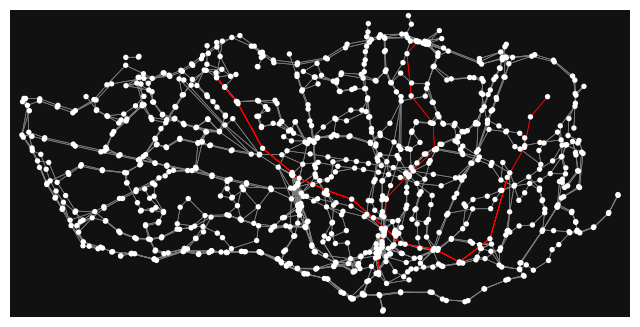

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [54]:
# edges red if metro
ox.plot_graph(G, edge_color=['red' if 'metro' in d.get('mode') else 'gray' for u,v,d in G.edges(data=True)], edge_linewidth=0.5)


# Path example

In [10]:
# Origin
orig_address = "Av. da Boavista 604-610, 4149-071 Porto"
orig_y, orig_x = ox.geocode(orig_address)  # notice the coordinate order (y, x)!

# Destination
dest_address = "Rua D. Frei Vicente da Soledade e Castro, Porto"
dest_y, dest_x = ox.geocode(dest_address) 

print("Origin coords:", orig_x, orig_y)
print("Destination coords:", dest_x, dest_y)

Origin coords: -8.6307703 41.1590784
Destination coords: -8.598334783806017 41.1776997243421


In [11]:
# 1. Find the closest nodes for origin and destination
orig_node_id, dist_to_orig = ox.distance.nearest_nodes(G, X=orig_x, Y=orig_y, return_dist=True)
dest_node_id, dist_to_dest = ox.distance.nearest_nodes(G, X=dest_x, Y=dest_y, return_dist=True)

print("Origin node-id:", orig_node_id, "and distance:", dist_to_orig, "meters.")
print("Destination node-id:", dest_node_id, "and distance:", dist_to_dest, "meters.")

Origin node-id: BCM4 and distance: 51.74511646938983 meters.
Destination node-id: FEUP2 and distance: 157.7244153477641 meters.


In [ ]:
# Calculate the paths
metric_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='length')
time_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='travel_time_seconds')

# Get also the actual travel times (summarize)
travel_length = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='length')
travel_time = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='travel_time_seconds')

In [ ]:
fig, ax = ox.plot_graph_route(G, metric_path)  # ou time_path

# Add the travel time as title
ax.set_xlabel("Shortest path distance {t: .1f} meters.".format(t=travel_length))

In [ ]:
ox.plot_route_folium(G, metric_path)  # visualização diferente da mesma coisa


# Statistical sections/sectors

In [ ]:
sections = gpd.read_file(data_folder + "sections.gpkg")
# sections.crs = "EPSG:4326"

# sections.geometry = sections.geometry.centroid
# rename column DTMNFRSEC21 to id
sections.rename(columns={'DTMNFRSEC21': 'id'}, inplace=True)

In [ ]:
ax = sections.plot("N_INDIVIDUOS", scheme="natural_breaks", cmap="Reds", figsize=(12,12), legend=True, markersize=3.5)
cx.add_basemap(ax, crs=sections.crs)

In [ ]:
# matrix = pd.DataFrame({'from_id': sections['id'].values.repeat(len(sections)), 'to_id': np.tile(sections['id'].values, len(sections))})
# ...

matrix = joblib.load(data_folder + 'matrix.pkl')

In [ ]:
matrix

metric_path é de ter corrido o djikstra entre todos os nós e guardado o caminho mais curto entre cada par de nós (demorou 6 horas e o topo da rede estava cortada/interrompida)

metric_path2 é de ter corrido o floyd_warshall e guardado o caminho mais curto entre cada par de nós
(demorou menos de 10 minutos)

In [ ]:
sections_nearest = sections.copy()
sections_nearest['nearest_node'] = sections.apply(lambda x: ox.distance.nearest_nodes(G, x.geometry.centroid.x, x.geometry.centroid.y), axis=1)

In [ ]:
# demora uns 5 min a correr

floyd_predecessors, floyd_distances = nx.floyd_warshall_predecessor_and_distance(G, weight='length')

## Create Walking Edges on Current Network

In [55]:

# Create a copy of the original graph to preserve it
G_with_walking = G.copy()

# Count original edges
original_edges = G.number_of_edges()

# Maximum walking distance in meters
MAX_WALKING_DISTANCE = 300
WALKING_SPEED = 1.2  # meters per second (about 5 km/h)

# Get node positions
node_positions = {node: (data['y'], data['x'])  # (lat, lon)
                 for node, data in G.nodes(data=True)}

# Add a progress counter
total_nodes = len(G.nodes())
processed_nodes = 0
walking_edges_added = 0

for node1 in G.nodes():
    pos1 = node_positions[node1]  # (lat, lon)

    for node2 in G.nodes():
        if node1 != node2:
            pos2 = node_positions[node2]  # (lat, lon)

            # Calculate actual distance in meters
            # first convert pos1 and pos2 to osmium geom.Coordinates
            pos1_ = osmium.geom.Coordinates(pos1[1], pos1[0])
            pos2_ = osmium.geom.Coordinates(pos2[1], pos2[0])
            distance = haversine_distance(pos1_, pos2_)

            if distance <= MAX_WALKING_DISTANCE and not G_with_walking.has_edge(node1, node2):
                G_with_walking.add_edge(node1, node2,
                                      length=distance,
                                      travel_time_seconds=distance/WALKING_SPEED,
                                      mode='walking')
                walking_edges_added += 1

final_edges = G_with_walking.number_of_edges()

print(f"Walking edges added: {walking_edges_added}")
print(f"Total edges in new network: {final_edges}")
print(f"Percentage increase: {((final_edges/original_edges) - 1)*100:.1f}%")

Walking edges added: 6130
Total edges in new network: 8784
Percentage increase: 231.0%


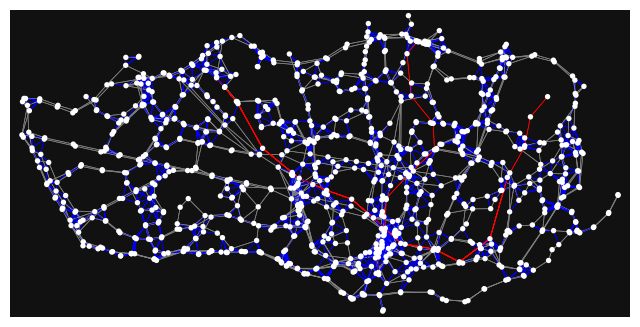

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [56]:
# Visualization
ox.plot_graph(G_with_walking,
              edge_color=['blue' if d.get('mode')=='walking' else 'red' if d.get('mode')=='metro' else 'gray' for u,v,d in G_with_walking.edges(data=True)],
              edge_linewidth=0.5)

## Join Metro with nearest Bus node (4 edges added because walking edges already got most of them)

In [57]:
# for all nodes in the metro network, find the nearest node in the bus network and add a walking edge
G_metro_connected = G_with_walking.copy()
# without all metro nodes
G_without_metro = G.copy()
G_without_metro.remove_nodes_from(metro_nodes['id'].values)
new_edge_counter = 0
for _, metro_node in metro_nodes.iterrows():
    # get G with metro_node dropped
    # G_ = G_metro_connected.copy()
    # G_.remove_node(metro_node['id'])
    nearest_node, dist = ox.distance.nearest_nodes(G_without_metro, X=metro_node['lon'], Y=metro_node['lat'], return_dist=True)
    # compute haversine distance
    pos1 = (metro_node['lat'], metro_node['lon'])
    pos2 = (G.nodes[nearest_node]['y'], G.nodes[nearest_node]['x'])
    pos1_ = osmium.geom.Coordinates(pos1[1], pos1[0])
    pos2_ = osmium.geom.Coordinates(pos2[1], pos2[0])
    h_dist = haversine_distance(pos1_, pos2_)
    # print(f"Nearest node: {nearest_node}, distance: {dist}, haversine_distance: {h_dist}")
    
    if not G_metro_connected.has_edge(nearest_node, metro_node['id']):
        G_metro_connected.add_edge(nearest_node, metro_node['id'], length=h_dist, travel_time_seconds=h_dist/WALKING_SPEED, mode='walking', tag='metro_nearest_bus')
        new_edge_counter += 1
    if not G_metro_connected.has_edge(metro_node['id'], nearest_node):  
        G_metro_connected.add_edge(metro_node['id'], nearest_node, length=h_dist,  travel_time_seconds=h_dist/WALKING_SPEED, mode='walking', tag='metro_nearest_bus')
        new_edge_counter += 1

In [58]:
new_edge_counter

4

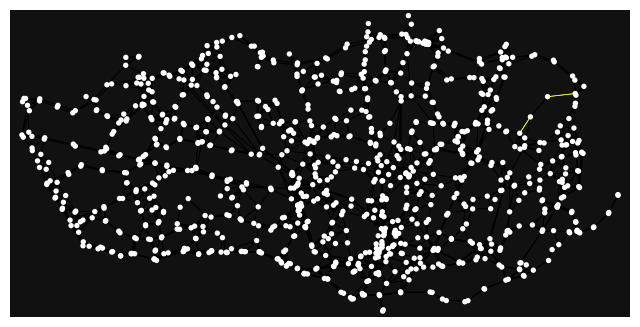

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [59]:
# plot
ox.plot_graph(G_metro_connected, edge_color=['yellow' if d.get('tag') == 'metro_nearest_bus' else 'black' if d.get('mode')=='walking' else 'black' if d.get('mode')=='metro' else 'black' for u,v,d in G_metro_connected.edges(data=True)], edge_linewidth=0.5)


## Join Bus with nearest Metro node (474 edges added)

In [60]:
MAX_WALKING_DISTANCE_TO_METRO = 1200
# for all nodes in the bus network, find the nearest node in the metro network and add a walking edge if the distance is less than 1000 meters
G_bus_connected = G_metro_connected.copy()
# without all bus nodes
G_without_bus = G.copy()
G_without_bus.remove_nodes_from(stcp_nodes['id'].values)
new_edge_counter = 0
for _, bus_node in stcp_nodes.iterrows():
    # get G with bus_node dropped
    # G_ = G_bus_connected.copy()
    # G_.remove_node(bus_node['id'])
    nearest_node, dist = ox.distance.nearest_nodes(G_without_bus, X=bus_node['lon'], Y=bus_node['lat'], return_dist=True)
    # compute haversine distance
    pos1 = (bus_node['lat'], bus_node['lon'])
    pos2 = (G.nodes[nearest_node]['y'], G.nodes[nearest_node]['x'])
    pos1_ = osmium.geom.Coordinates(pos1[1], pos1[0])
    pos2_ = osmium.geom.Coordinates(pos2[1], pos2[0])
    h_dist = haversine_distance(pos1_, pos2_)
    # print(f"Nearest node: {nearest_node}, distance: {dist}, haversine_distance: {h_dist}")
    if h_dist > MAX_WALKING_DISTANCE_TO_METRO or G_bus_connected.has_edge(bus_node['id'], nearest_node): # this is not the MAX_WALKING_DISTANCE used previously because people may be willing to walk more to get to a metro station
        continue
    new_edge_counter += 1
    
    # check if such edge alreafy exists
    G_bus_connected.add_edge(bus_node['id'], nearest_node, length=h_dist, travel_time_seconds=h_dist/WALKING_SPEED, mode='walking', tag='bus_nearest_metro')
    
    if h_dist > MAX_WALKING_DISTANCE or G_bus_connected.has_edge(nearest_node, bus_node['id']):  # walking from the metro to a "random" bus stop is not as desirable
        continue
    
    new_edge_counter += 1
    G_bus_connected.add_edge(nearest_node, bus_node['id'], length=h_dist, travel_time_seconds=h_dist/WALKING_SPEED, mode='walking', tag='bus_nearest_metro')

In [35]:
G_metro_connected.nodes(data=True)

NodeDataView({'1ADA1': {'osmid': '1ADA1', 'timestamp': Timestamp('2024-11-16 14:31:45.227000'), 'tags': 'bus', 'visible': True, 'version': 1, 'x': -8.61355552858081, 'y': 41.1716440199193, 'changeset': 1, 'geometry': <POINT (-8.614 41.172)>}, '1AL2': {'osmid': '1AL2', 'timestamp': Timestamp('2024-11-16 14:31:45.227000'), 'tags': 'bus', 'visible': True, 'version': 1, 'x': -8.6100690279121, 'y': 41.1495147366521, 'changeset': 1, 'geometry': <POINT (-8.61 41.15)>}, '1AL6': {'osmid': '1AL6', 'timestamp': Timestamp('2024-11-16 14:31:45.227000'), 'tags': 'bus', 'visible': True, 'version': 1, 'x': -8.6100096776489, 'y': 41.1491175343024, 'changeset': 1, 'geometry': <POINT (-8.61 41.149)>}, '1BS2': {'osmid': '1BS2', 'timestamp': Timestamp('2024-11-16 14:31:45.227000'), 'tags': 'bus', 'visible': True, 'version': 1, 'x': -8.62776236753369, 'y': 41.155925167507, 'changeset': 1, 'geometry': <POINT (-8.628 41.156)>}, '1BS3': {'osmid': '1BS3', 'timestamp': Timestamp('2024-11-16 14:31:45.227000'), 't

In [32]:
G_bus_connected.edges(data=True)

OutMultiEdgeDataView([('1ADA1', 'CI31', {'u': '1ADA1', 'v': 'CI31', 'mode': '704_0', 'access': None, 'area': None, 'bicycle': None, 'bridge': None, 'busway': None, 'cycleway': None, 'foot': None, 'footway': None, 'highway': None, 'int_ref': None, 'junction': None, 'lanes': 2, 'lit': None, 'maxspeed': None, 'motorcar': None, 'motorroad': None, 'motor_vehicle': None, 'name': None, 'oneway': 'no', 'psv': None, 'ref': None, 'service': None, 'segregated': None, 'sidewalk': None, 'smoothness': None, 'surface': None, 'tracktype': 'bus', 'tunnel': None, 'turn': None, 'width': None, 'osmid': '704_0:i', 'timestamp': '2024-12-28T01:11:31.966999', 'version': 1, 'tags': None, 'osm_type': 'way', 'length': 254.50848759118074, 'travel_time_seconds': 38.157194541406405, 'geometry': <LINESTRING (-8.614 41.172, -8.613 41.174)>, 'key': 0}), ('1ADA1', '1R9A1', {'u': '1ADA1', 'v': '1R9A1', 'mode': '704_0', 'access': None, 'area': None, 'bicycle': None, 'bridge': None, 'busway': None, 'cycleway': None, 'foot

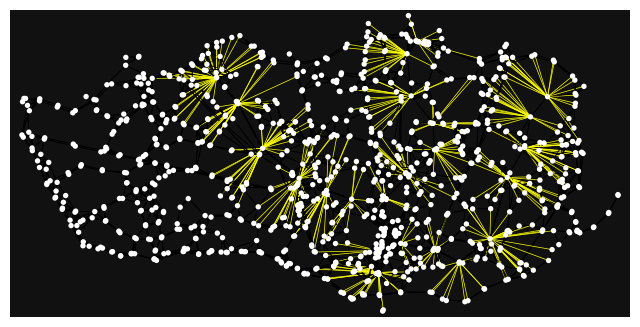

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [61]:
# plot
ox.plot_graph(G_bus_connected, edge_color=['yellow' if d.get('tag') == 'bus_nearest_metro' else 'black' if d.get('mode')=='walking' else 'black' if d.get('mode')=='metro' else 'black' for u,v,d in G_bus_connected.edges(data=True)], edge_linewidth=0.5)

In [62]:
new_edge_counter

521

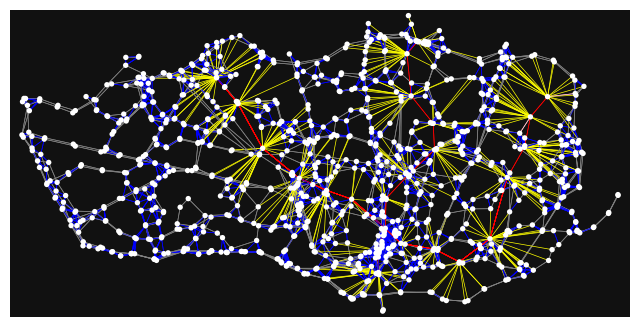

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [63]:
# plot every type of edge
ox.plot_graph(G_bus_connected, edge_color=['yellow' if d.get('tag') == 'bus_nearest_metro' else 'pink' if d.get('tag') == 'metro_nearest_bus' else 'blue' if d.get('mode')=='walking' else 'red' if d.get('mode')=='metro' else 'gray' for u,v,d in G_bus_connected.edges(data=True)], edge_linewidth=0.5)

In [73]:
nx.number_connected_components(G_bus_connected.to_undirected())

1

In [64]:
# store the graph nodes and edges as gpkg
gdf_nodes = ox.graph_to_gdfs(G_bus_connected, edges=False)
gdf_edges = ox.graph_to_gdfs(G_bus_connected, nodes=False)

In [65]:
# some nodes have NaN osmid (the metro nodes)
i=1
for idx, row in gdf_nodes.iterrows():
    if not type(row['osmid']) == str:
        i+=1
        gdf_nodes.at[idx, 'osmid'] = idx

In [66]:
gdf_nodes['osmid'].isna().sum()


0

In [67]:
gdf_nodes['osmid'].duplicated().sum()

0

In [68]:
# column osmid is duplicated, rename the index column
gdf_nodes.rename(columns={'osmid': 'id'}, inplace=True)

In [74]:
gdf_nodes.to_file(data_folder + "porto_nodes_time.gpkg", driver="GPKG")
gdf_edges.to_file(data_folder + "porto_edges_time.gpkg", driver="GPKG")

In [75]:
gdf_nodes

id               timestamp   tags  visible  version         x  \
osmid                                                                     
1ADA1  1ADA1 2024-11-16 14:31:45.227    bus     True        1 -8.613556   
1AL2    1AL2 2024-11-16 14:31:45.227    bus     True        1 -8.610069   
1AL6    1AL6 2024-11-16 14:31:45.227    bus     True        1 -8.610010   
1BS2    1BS2 2024-11-16 14:31:45.227    bus     True        1 -8.627762   
1BS3    1BS3 2024-11-16 14:31:45.227    bus     True        1 -8.628206   
...      ...                     ...    ...      ...      ...       ...   
5775    5775 2024-11-16 14:13:07.127  metro     True        1 -8.604272   
5776    5776 2024-11-16 14:13:07.127  metro     True        1 -8.603607   
5777    5777 2024-11-16 14:13:07.127  metro     True        1 -8.598744   
5778    5778 2024-11-16 14:13:07.127  metro     True        1 -8.610815   
5791    5791 2024-11-16 14:13:07.127  metro     True        1 -8.602240   

               y  changeset                   geometry  
osmid                                                   
1ADA1  41.171644          1  POINT (-8.61356 41.17164)  
1AL2   41.149515          1  POINT (-8.61007 41.14951)  
1AL6   41.149118          1  POINT (-8.61001 41.14912)  
1BS2   41.155925          1  POINT (-8.62776 41.15593)  
1BS3   41.154471          1  POINT (-8.62821 41.15447)  
...          ...        ...                        ...  
5775   41.161120          1  POINT (-8.60427 41.16112)  
5776   41.174250          1  POINT (-8.60361 41.17425)  
5777   41.169690          1  POINT (-8.59874 41.16969)  
5778   41.144940          1  POINT (-8.61082 41.14494)  
5791   41.183260          1  POINT (-8.60224 41.18326)  

[1008 rows x 9 columns]

In [77]:
# load the graph
porto_nodes = gpd.read_file(data_folder + "porto_nodes_time.gpkg")
porto_edges = gpd.read_file(data_folder + "porto_edges_time.gpkg")


G = osm.to_graph(porto_nodes, porto_edges, graph_type='networkx', node_id_col='osmid')

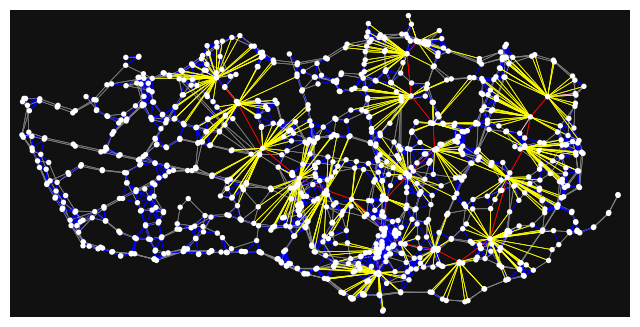

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [78]:
ox.plot_graph(G, edge_color=['yellow' if d.get('tag') == 'bus_nearest_metro' else 'pink' if d.get('tag') == 'metro_nearest_bus' else 'blue' if d.get('mode')=='walking' else 'red' if d.get('mode')=='metro' else 'gray' for u,v,d in G.edges(data=True)], edge_linewidth=0.5)

In [79]:
porto_edges

u      v  key     mode access  area bicycle bridge busway cycleway  \
0     1ADA1   CI31    0    704_0   None  None    None   None   None     None   
1     1ADA1  1R9A1    0    704_0   None  None    None   None   None     None   
2     1ADA1   ADA2    0  walking   None  None    None   None   None     None   
3     1ADA1   ADA3    0  walking   None  None    None   None   None     None   
4     1ADA1   ADA4    0  walking   None  None    None   None   None     None   
...     ...    ...  ...      ...    ...   ...     ...    ...    ...      ...   
9304   5791   HSJ7    0  walking   None  None    None   None   None     None   
9305   5791   HSJ8    0  walking   None  None    None   None   None     None   
9306   5791   HSJ9    0  walking   None  None    None   None   None     None   
9307   5791   IPO2    0  walking   None  None    None   None   None     None   
9308   5791   IPO4    0  walking   None  None    None   None   None     None   

      ... width    osmid                   timestamp version  tags  osm_type  \
0     ...  None  704_0:i  2024-12-28T01:11:31.966999     1.0  None       way   
1     ...  None  704_0:i  2024-12-28T01:11:31.964001     1.0  None       way   
2     ...  None     None                        None     NaN  None      None   
3     ...  None     None                        None     NaN  None      None   
4     ...  None     None                        None     NaN  None      None   
...   ...   ...      ...                         ...     ...   ...       ...   
9304  ...  None     None                        None     NaN  None      None   
9305  ...  None     None                        None     NaN  None      None   
9306  ...  None     None                        None     NaN  None      None   
9307  ...  None     None                        None     NaN  None      None   
9308  ...  None     None                        None     NaN  None      None   

          length travel_time_seconds   tag  \
0     254.508488           38.157195  None   
1     398.218734           59.702959  None   
2      81.478113           67.898428  None   
3     113.531265           94.609388  None   
4     116.676918           97.230765  None   
...          ...                 ...   ...   
9304  167.226248          139.355206  None   
9305  191.604402          159.670335  None   
9306  211.813830          176.511525  None   
9307  129.720037          108.100031  None   
9308  193.917108          161.597590  None   

                                               geometry  
0     LINESTRING (-8.61356 41.17164, -8.61319 41.17392)  
1     LINESTRING (-8.61786 41.17012, -8.61356 41.17164)  
2     LINESTRING (-8.61356 41.17164, -8.61448 41.17188)  
3     LINESTRING (-8.61356 41.17164, -8.61296 41.17073)  
4     LINESTRING (-8.61356 41.17164, -8.61274 41.17079)  
...                                                 ...  
9304  LINESTRING (-8.60224 41.18326, -8.60032 41.18284)  
9305  LINESTRING (-8.60224 41.18326, -8.60001 41.18286)  
9306  LINESTRING (-8.60224 41.18326, -8.59978 41.18280)  
9307  LINESTRING (-8.60224 41.18326, -8.60379 41.18333)  
9308  LINESTRING (-8.60224 41.18326, -8.60439 41.18392)  

[9309 rows x 43 columns]

In [80]:
porto_nodes

osmid     id               timestamp   tags  visible  version         x  \
0     1ADA1  1ADA1 2024-11-16 14:31:45.227    bus     True        1 -8.613556   
1      1AL2   1AL2 2024-11-16 14:31:45.227    bus     True        1 -8.610069   
2      1AL6   1AL6 2024-11-16 14:31:45.227    bus     True        1 -8.610010   
3      1BS2   1BS2 2024-11-16 14:31:45.227    bus     True        1 -8.627762   
4      1BS3   1BS3 2024-11-16 14:31:45.227    bus     True        1 -8.628206   
...     ...    ...                     ...    ...      ...      ...       ...   
1003   5775   5775 2024-11-16 14:13:07.127  metro     True        1 -8.604272   
1004   5776   5776 2024-11-16 14:13:07.127  metro     True        1 -8.603607   
1005   5777   5777 2024-11-16 14:13:07.127  metro     True        1 -8.598744   
1006   5778   5778 2024-11-16 14:13:07.127  metro     True        1 -8.610815   
1007   5791   5791 2024-11-16 14:13:07.127  metro     True        1 -8.602240   

              y  changeset                   geometry  
0     41.171644          1  POINT (-8.61356 41.17164)  
1     41.149515          1  POINT (-8.61007 41.14951)  
2     41.149118          1  POINT (-8.61001 41.14912)  
3     41.155925          1  POINT (-8.62776 41.15593)  
4     41.154471          1  POINT (-8.62821 41.15447)  
...         ...        ...                        ...  
1003  41.161120          1  POINT (-8.60427 41.16112)  
1004  41.174250          1  POINT (-8.60361 41.17425)  
1005  41.169690          1  POINT (-8.59874 41.16969)  
1006  41.144940          1  POINT (-8.61082 41.14494)  
1007  41.183260          1  POINT (-8.60224 41.18326)  

[1008 rows x 10 columns]